0. Config.py snapshot

```python
import os

import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F
import fiftyone.brain as fob 


# Dataset Zoo
## list of str / None for download all
DATASET_ZOO_NAME   = 'open-images-v6'
DATASET_MOD_NAME   = DATASET_ZOO_NAME + '_mod'
## list of str / None for download all
DATASET_ZOO_SPLITS = ["train", 'test', 'validation']
## list of str / None for default dir
DATASET_ZOO_DIR    = os.path.expanduser('~/fiftyone')
# Filter configs
CLASSES_OF_INTEREST = [
    "Motorcycle", "Car", "Truck",
    "Bus", "Taxi", "Van", "Land vehicle",
    # "Tank", "Train", "Vehicle", 
]

LABEL_TYPES = [
    "detections", 
    # "classifications", 
    # "segmentations", 
    # "relationships",
]

# The name of the sample field containing the label that you wish to export
# Used when exporting labeled datasets (e.g., classification or detection)
# LABEL_FIELD = "ground_truth"
LABEL_FIELD = "detections"

## Aug
DATASET_AUG_NAME   = DATASET_ZOO_NAME + "_aug"
DATASET_AUG_SPLITS = DATASET_ZOO_SPLITS + [i+"_aug" for i in DATASET_ZOO_SPLITS]


# Filter+_data.ipynb
DATASET_TO_FILTER  = DATASET_ZOO_NAME


EXPORT_DIR = "export"

################################################################################
################################################################################


# Model Zoo
ZOO_MODEL_NAME     = ""
DETECTION_FIELD    = ""


################################################################################
################################################################################



################################################################################
################################################################################


# The directory to which to write the exported dataset
## Filter_data.ipynb


# dataset_type = fo.types.COCODetectionDataset  # COCO
EXPORT_DATASET_TYPE = fo.types.dataset_types.YOLOv5Dataset # YOLOv5



```

# 1 Download

In [1]:
%load_ext autoreload
%autoreload 2

try:
    import umap # for visualization
except ImportError:
    !pip install numpy==1.20 scipy scikit-learn numba umap-learn

import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F
import fiftyone.brain as fob
import fiftyone.utils.eval as foue
import config

import cv2

if config.DATASET_ZOO_DIR is not None:
    fo.config.dataset_zoo_dir = config.DATASET_ZOO_DIR
    print(f"Change dataset_zoo_dir to {fo.config.dataset_zoo_dir}")
ds = foz.list_zoo_datasets()
print(ds)

Change dataset_zoo_dir to /home/dhp/fiftyone
['bdd100k', 'caltech101', 'caltech256', 'cifar10', 'cifar100', 'cityscapes', 'coco-2014', 'coco-2017', 'fashion-mnist', 'hmdb51', 'imagenet-2012', 'imagenet-sample', 'kitti', 'lfw', 'mnist', 'open-images-v6', 'quickstart', 'quickstart-geo', 'quickstart-video', 'ucf101', 'voc-2007', 'voc-2012']


In [3]:
from IPython.display import clear_output
session = fo.launch_app() 
# session.open_tab()
clear_output()

In [ ]:
if config.DATASET_ZOO_NAME is None:
    # Download all
    ds = foz.list_zoo_datasets()
    ds.remove('bdd100k')

    for ds_name in ds:
        try:
            print(foz.download_zoo_dataset(ds_name))
        except:
            print('skip')
else:
    # Download specific dataset
    if config.DATASET_ZOO_NAME in foz.list_downloaded_zoo_datasets():
        dsname = config.DATASET_MOD_NAME
    else:
        dsname = config.DATASET_ZOO_NAME
    
    dataset = foz.load_zoo_dataset(
        name         = config.DATASET_ZOO_NAME,
        splits       = config.DATASET_ZOO_SPLITS,
        classes      = config.CLASSES_OF_INTEREST,
        dataset_name = dsname,
        label_types  = config.LABEL_TYPES,
        cleanup      = True,
        download_if_neccessary = True,
        # overwrite    = True,
        # max_samples=100,
        # seed=51,
        # shuffle=True,        
    )

dataset.persistent = True
dataset

# 2. Filter data

# Filter label by class

In [9]:
#####
view = dataset.filter_labels(config.LABEL_FIELD, F("label").is_in(config.CLASSES_OF_INTEREST))
# dataset = dataset.match_tags('validation')

In [7]:
session.view = view
clear_output()

# Remove duplicates

In [44]:
IOU_THRES = 0.75

foue.compute_max_ious(view, config.LABEL_FIELD, attr_name="max_iou", classwise=True)

# Retrieve detections that overlap above a chosen threshold
dups_view = dataset.filter_labels(config.LABEL_FIELD, F("max_iou") >= IOU_THRES)
session.view = dups_view
clear_output()

In [46]:
# # Method 2: Delete all images filtered by the expression
dataset.delete_samples(dups_view)

# Calculate uniqueness


In [ ]:
fob.compute_uniqueness(view)
dataset.save()

# Calculate similarity


In [ ]:
fob.compute_similarity(view, brain_key="image_sim")
dataset.save()

In [14]:
## Go to fiftyone-app, manually check for irrelevant images and mark sample tag = 'del' then run this cell
## ONLY RUN THIS RIGHT AFTER EXPORT
dataset.delete_samples(dataset.match_tags("del"))

# Export - Augment - Reload

In [14]:
view = dataset.view()
view.count_sample_tags()

{'test': 15031, 'train': 7708, 'validation': 5007}

In [17]:
# Use when any change applied to dataset
for split in config.DATASET_ZOO_SPLITS:
    print(f'Exporting {split}')
    split_view = view.match_tags(split)

    # Export the dataset
    split_view.export(
        export_dir=config.EXPORT_DIR,
        dataset_type=config.EXPORT_DATASET_TYPE,
        label_field=config.LABEL_FIELD,
        classes=config.CLASSES_OF_INTEREST,
        split=split,
    )
dataset.count_sample_tags()

 100% |███████████████| 7708/7708 [1.5m elapsed, 0s remaining, 84.6 samples/s]        
Directory 'export' already exists; export will be merged with existing files
 100% |█████████████| 15031/15031 [2.7m elapsed, 0s remaining, 108.2 samples/s]      
Directory 'export' already exists; export will be merged with existing files
 100% |███████████████| 5007/5007 [48.5s elapsed, 0s remaining, 113.8 samples/s]      
Directory 'export' already exists; export will be merged with existing files
 100% |█████████████████████| 0/0 [16.3ms elapsed, ? remaining, ? samples/s] 
Directory 'export' already exists; export will be merged with existing files
 100% |█████████████████████| 0/0 [17.9ms elapsed, ? remaining, ? samples/s] 
Directory 'export' already exists; export will be merged with existing files
 100% |█████████████████████| 0/0 [17.0ms elapsed, ? remaining, ? samples/s] 


{'test': 15031, 'validation': 5007, 'train': 7708}

In [ ]:
# Move all samples and labels in "validattion" to "train"

In [18]:
%%bash

# ! pip install albumentations tqdm

# change "export" to relevant folder
python augment_box.py\
    -si 'export/images/train'\
    -sl 'export/labels/train'\
    -di 'export/images/train_aug'\
    -dl 'export/labels/train_aug'\
    -n 2

Start Augment export/images/train export/labels/train export/images/train_aug export/labels/train_aug 2


100%|██████████| 12715/12715 [34:44<00:00,  6.10it/s] 


In [19]:
dataset

Name:        open-images-v6_mod
Media type:  image
Num samples: 27746
Persistent:  True
Tags:        ['test', 'train', 'validation']
Sample fields:
    id:             fiftyone.core.fields.ObjectIdField
    filepath:       fiftyone.core.fields.StringField
    tags:           fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    detections:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    open_images_id: fiftyone.core.fields.StringField
    lightness:      fiftyone.core.fields.FloatField
    contrast:       fiftyone.core.fields.FloatField
    uniqueness:     fiftyone.core.fields.FloatField

In [20]:
# # Load dataset from the directories

# Load the dataset, using tags to mark the samples in each split
dataset = fo.Dataset(config.DATASET_AUG_NAME)
for split in config.DATASET_AUG_SPLITS:
    dataset.add_dir(
        dataset_dir=config.EXPORT_DIR,
        dataset_type=config.EXPORT_DATASET_TYPE,
        split=split,
        tags=split,
)
dataset.persistent = True

 100% |█████████████| 12715/12715 [44.6s elapsed, 0s remaining, 781.2 samples/s]      
 100% |█████████████| 15031/15031 [1.2m elapsed, 0s remaining, 166.1 samples/s]      
 100% |█████████████████████| 0/0 [650.9us elapsed, ? remaining, ? samples/s] 
 100% |█████████████| 22970/22970 [1.1m elapsed, 0s remaining, 759.9 samples/s]      
 100% |█████████████████████| 0/0 [394.8us elapsed, ? remaining, ? samples/s] 
 100% |█████████████████████| 0/0 [366.3us elapsed, ? remaining, ? samples/s] 


In [16]:
print(dataset.count_sample_tags())
dataset

{'test': 15026, 'train_aug': 22375, 'train': 12710}


Name:        open-images-v6_aug
Media type:  image
Num samples: 50111
Persistent:  True
Tags:        ['test', 'train', 'train_aug']
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    lightness:    fiftyone.core.fields.FloatField
    contrast:     fiftyone.core.fields.FloatField

In [17]:
view = dataset.view()
session.view = view
clear_output()

# Lowest lightness from boxes in img

In [28]:
view.compute_metadata()

Computing image metadata...
  44% |█████/-------| 22507/50716 [4.3m elapsed, 5.3m remaining, 92.5 samples/s]     

Corrupt JPEG data: bad Huffman code


 100% |█████████████| 50716/50716 [9.4m elapsed, 0s remaining, 122.3 samples/s]      


In [36]:
fp = view.values('filepath')[38945]
img = cv2.imread(fp)
hsv = cv2.cvtColor(box_img,cv2.COLOR_BGR2HSV)


'/home/dhp/DATA/0.Project/personal/get_data/export/images/train_aug/0952869ab4eb4107_aug_1.jpg'

In [53]:
import cv2
import numpy as np
from tqdm import tqdm

lightness_values = []
contrast_values = []

for ix, sample in tqdm(enumerate(view)):
    # if ix < 35000:
    #     continue
    fp  = sample.filepath
    img = cv2.imread(fp)
    h, w = img.shape[:2]
    dets = sample.ground_truth.detections
    
    v = 300
    for det in dets:
        x1, y1, wl, hl = det.bounding_box
        x2 = int((x1+wl)*w)
        y2 = int((y1+hl)*h)
        x1 = int(x1*w)
        y1 = int(y1*h)
        box_img = img[y1:y2, x1:x2]
        if box_img.size==0: # some box has 0 width / height, set 0 to all and stop looping`
            v = c = 0
            break
        else:
            hsv = cv2.cvtColor(box_img,cv2.COLOR_BGR2HSV)
            new_v = np.mean(hsv[...,[2]])
            if new_v < v:
                v = new_v
                c = np.std(hsv[...,[2]])
                
    if v == 300:
        v = c = 0
    lightness_values.append(v)
    contrast_values.append(c)

    
view.set_values('lightness', lightness_values)
view.set_values('contrast', contrast_values)

light_view = view.sort_by("lightness")
session.view = light_view
clear_output()

=> go to 51-APP, find relevant lightness threshold and contrast threshold and update to `config.LIGHTNESS_THRESHOLD`, `config.CONTRAST_THRESHOLD`

In [90]:
# RUN WITH CAUTION
del_ids = []
for ix, id_ in enumerate(view.values('id')):
    if lightness_values[ix]<config.LIGHTNESS_THRESHOLD or contrast_values[ix]<config.CONTRAST_THRESHOLD:
        del_ids.append(id_)
        
print(len(del_ids),'images to delete')
dataset.delete_samples(del_ids)

605 images to delete


=> review remain dataset in the app. Update config and re-run filter if needed.

# Final export

In [121]:
# Use when any change applied to dataset
for split in view.count_sample_tags().keys():
    print(f'Exporting {split}')
    split_view = view.match_tags(split)

    # Export the dataset
    split_view.export(
        export_dir=config.EXPORT_DIR+'_filtered',
        dataset_type=config.EXPORT_DATASET_TYPE,
        label_field='ground_truth',
        classes=config.CLASSES_OF_INTEREST,
        split=split,
    )
dataset.count_sample_tags()

Exporting train
 100% |█████████████| 12710/12710 [1.7m elapsed, 0s remaining, 124.7 samples/s]       
Exporting test
Directory 'export_filtered' already exists; export will be merged with existing files
 100% |█████████████| 15026/15026 [1.8m elapsed, 0s remaining, 219.5 samples/s]      
Exporting train_aug
Directory 'export_filtered' already exists; export will be merged with existing files
 100% |█████████████| 22375/22375 [2.4m elapsed, 0s remaining, 206.5 samples/s]      


{'train': 12710, 'test': 15026, 'train_aug': 22375}

# Visualize dataset

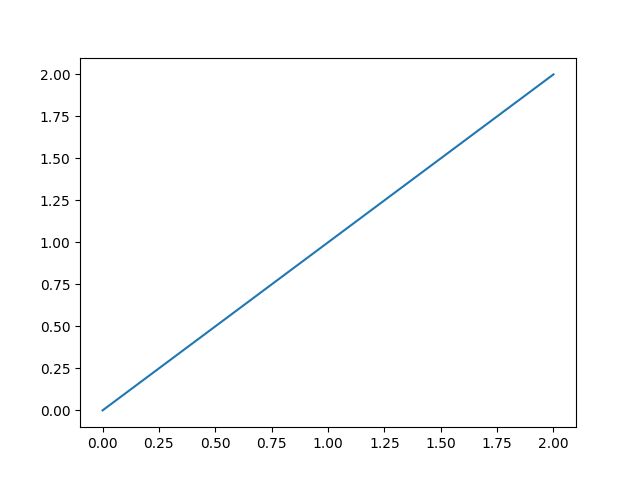

In [4]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.plot([0, 1, 2])

In [5]:
dataset = fo.load_dataset(config.DATASET_AUG_NAME)

In [11]:
view = dataset.view()

In [12]:
session.view=view
clear_output()

In [13]:
model = foz.load_zoo_model("mobilenet-v2-imagenet-torch")
embeddings = view.compute_embeddings(
    model,
    # patches_field="predictions",
    num_dims=2,
    method="umap",
    verbose=True,
    seed=51,)

# Compute visualization
results = fob.compute_visualization(view, embeddings=embeddings, seed=51)

 100% |█████████████| 50111/50111 [3.9h elapsed, 0s remaining, 3.6 samples/s]      
Generating visualization...
UMAP(random_state=51, verbose=True)
Mon Dec 20 03:08:09 2021 Construct fuzzy simplicial set
Mon Dec 20 03:08:09 2021 Finding Nearest Neighbors
Mon Dec 20 03:08:09 2021 Building RP forest with 16 trees
Mon Dec 20 03:08:14 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Mon Dec 20 03:08:28 2021 Finished Nearest Neighbor Search
Mon Dec 20 03:08:29 2021 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Mon Dec 20 03:09:02 2021 Finished embedding


In [9]:
embeddings.shape

(100, 1280)

In [14]:
view.set_values('embeddings', embeddings)

In [ ]:
%matplotlib widget

# if error "Error displaying widget: model not found" => try jupyter notebook instead of jupyter lab
# or see https://github.com/matplotlib/ipympl/issues/112#issuecomment-798781053

# Generate scatterplot
plot = results.visualize(
    labels='embeddings',
    # labels_title="time of day",
    # axis_equal=True,
)
plot.show(height=512)

# # Connect to session
session.plots.attach(plot)